In [175]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import re # Я буду использовать поиск по паттернам. Я считаю это очень удобным :)

In [176]:
CURRENT_DATE = pd.to_datetime('09/12/2020')

In [177]:
!pip install textblob

In [178]:
from textblob import TextBlob

In [179]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [180]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [181]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [182]:
# df_train.info()

In [183]:
# df_test.info()

In [184]:
# sample_submission.info()

In [185]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Словарь с населением городов в млн. чел

In [187]:
population_city_dict = {    'London': 8.173900,
    'Paris': 2.240621,
    'Madrid': 3.155360,
    'Barcelona': 1.593075,
    'Berlin': 3.326002,
    'Milan': 1.331586,
    'Rome': 2.870493,
    'Prague': 1.272690,
    'Lisbon': .547733,
    'Vienna': 1.765649,
    'Amsterdam': .825080,
    'Brussels': .144784,
    'Hamburg': 1.718187,
    'Munich': 1.364920,
    'Lyon': .496343,
    'Stockholm': 1.981263,
    'Budapest': 1.744665,
    'Warsaw': 1.720398,
    'Dublin': .506211 ,
    'Copenhagen': 1.246611,
    'Athens': 3.168846,
    'Edinburgh': .476100,
    'Zurich': .402275,
    'Oporto': .221800,
    'Geneva': .196150,
    'Krakow': .756183,
    'Oslo': .673469,
    'Helsinki': .574579,
    'Bratislava': .413192,
    'Luxembourg': .576249,
    'Ljubljana': .277554
    }

Словарь с общим количеством ресторанов по городу (взято на TripAdvisor ручками по каждому городу)

In [188]:
restaurant_all = {'Paris': 17016, 'Amsterdam': 3659, 'Athens': 2548, 'Barcelona': 9420, 'Berlin': 6610, 'Bratislava': 1261, 'Brussels': 3587, 'Copenhagen': 2321, 'Dublin': 2314, 'Edinburgh': 1880, 'Geneva': 1693, 'Hamburg': 3272, 'Helsinki': 1554, 'Krakow': 1745,
                  'Lisbon': 4854, 'Ljubljana': 600, 'London': 19739, 'Luxembourg': 736, 'Lyon': 2770, 'Madrid': 11069, 'Milan': 7375, 'Munich': 3138, 'Oporto': 1982, 'Oslo': 1253, 'Prague': 5390, 'Rome': 10836, 'Stockholm': 2969, 'Vienna': 4108, 'Warsaw': 3213, 'Zurich': 1859, 'Budapest': 3052}

Словарь с количеством ресторанов на 10000 жителей)

In [189]:
rest_per_10000 = {'Paris': 79.494,
 'Amsterdam': 42.56,
 'Athens': 38.854,
 'Barcelona': 58.136,
 'Berlin': 18.355,
 'Bratislava': 30.518,
 'Brussels': 247.748,
 'Copenhagen': 37.679,
 'Dublin': 41.832,
 'Edinburgh': 39.488,
 'Geneva': 86.311,
 'Hamburg': 17.874,
 'Helsinki': 24.158,
 'Krakow': 22.759,
 'Lisbon': 96.019,
 'Ljubljana': 21.617,
 'London': 22.462,
 'Luxembourg': 12.772,
 'Lyon': 53.714,
 'Madrid': 34.34,
 'Milan': 53.983,
 'Munich': 21.552,
 'Oporto': 89.36,
 'Oslo': 18.605,
 'Prague': 42.093,
 'Rome': 37.719,
 'Stockholm': 30.875,
 'Vienna': 22.319,
 'Warsaw': 18.275,
 'Zurich': 46.212,
 'Budapest': 17.443}

Словарь определения страны по городу

In [190]:
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}

Словарь туристических потоков по странам (в чел.)

In [191]:
dict_Tour = {'England' : 37651000, 'France' : 86861000, 'Spain' : 81786000, 
                  'Germany' : 37452000, 'Italy' : 58253000, 'Czech_c' : 10160000,  
                  'Portugal' : 15432000, 'Austria' : 29460000, 'Holland' : 17924000, 
                  'Belgium' : 8385000, 'Sweden' : 7054000, 'Romania' : 10926000, 
                  'Poland' : 18258000, 'Ireland' : 10338000, 'Denmark' : 11743000, 
                    'Greece' : 27194000, 'Scotland' : 10338000, 'Switzerland' : 9889000, 
                  'Norway' : 6252000, 'Finland' : 3180000, 'Slovakia' : 2162000, 
                  'Luxembourg_c' : 1046000, 'Slovenia' : 3586000}

Начнем обработки признаков.

### Restaurant_id

Оставим в Restaurant_id только цифровую часть

In [192]:
data['Restaurant_id_int'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

Создадим признак "Общее количество ресторанов в городе". Он нам понадобится для дальнейших процедур.

In [193]:
data['Restaurant_Count'] = data['City'].map(restaurant_all) 

Создадим признак "Количество ресторанов на 10000 человек"

In [194]:
data['Restaurant_per_10000'] = data['City'].map(rest_per_10000)

### Ranking

Посмотрим на ranking ресторана относительно общего количества ресторанов в городе

In [195]:
data['Ranking_Rel']=data['Ranking']/data['Restaurant_Count']

Сделаем признак - рейтинг (Ranking) ресторана относительно среднего рейтинга (Ranking) по городу

In [196]:
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
# count_Restorant_in_City = df['City'].value_counts(ascending=False)
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
# data['count_Restorant_in_City'] = data['City'].apply(lambda x: restaurant_all[x])
data['norm_Ranking_on_Rest_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['Restaurant_Count']

Продолжим "играть" с Ranking. Нормализуем этот признак относительно максимального по городу

In [197]:
max_Ranking_on_City = data.groupby(['City'])['Ranking'].max()
data['max_Ranking_on_City'] = data['City'].apply(lambda x: max_Ranking_on_City[x])
data['norm_Ranking_on_maxRank_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['max_Ranking_on_City']

Теперь Ranking относительно населения города

для начала сделаем признак с населением города (в тыс. чел)

In [198]:
data['Population'] = data['City'].map(population_city_dict)
data['Population']=data['Population']*1000

Теперь, собственно, Ranking

In [199]:
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
data['norm_Ranking_on_Popul_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['Population']

Чуть позже я добавлю еще Ranking относительно ресторанов с тем же типом кухни в городе. Но для начала как раз займусь стилями кухни.

### Cuisine Style

Для начала уберем из строк лишние знаки и переведем строки в списки

In [200]:
data['Cuisine Style'] = data['Cuisine Style'].str.replace("'|\]|\[|\n|\s", "").str.split(',')

Теперь заполним пропуски самой популярной кухней в городе

In [201]:
city_list = list(data.City.unique())
top_cuisine_city = {}
for city in city_list:
    cuisine = data[data.City == city].explode('Cuisine Style')['Cuisine Style'].value_counts().index[0]
    top_cuisine_city[city] = cuisine
for i in range(len(data['Cuisine Style'])):
    if str(data['Cuisine Style'].iloc[i]) == 'nan':
        data['Cuisine Style'].iloc[i] = top_cuisine_city[data['City'].iloc[i]]

Среди типов кухонь у нас есть и списки и строки. Переведем строки в список

In [202]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x if type(x) ==list else [x]) 

Добавим признак - наличие в ресторане редкой кухни. В качестве редкой я беру кухни, которые по value_counts занимают последние 20 мест

In [203]:
rare_cuisine_list = list(data.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending = True).index[0:30])
data['Rare_Cuisine'] = 0
for i in range (len(data['Cuisine Style'])):
    for item in rare_cuisine_list:
        if item in data['Cuisine Style'].iloc[i]:
            data['Rare_Cuisine'].iloc[i] = 1

Посчитаем количество кухонь в каждом ресторане

In [204]:
data['Cusine_Counts'] = data['Cuisine Style'].apply(lambda x: len(x))

Признак - количество кухонь в ресторане относительно среднего количества кухонь, представленных в ресторанах города

In [205]:
data['Cuisine Counts by City'] = 0
for i in range(len(data['Cusine_Counts'])):
    data['Cuisine Counts by City'].iloc[i] = data['Cusine_Counts'].iloc[i]/(data[data.City == data.City.iloc[i]].groupby(['City'])['Cusine_Counts'].mean()[0])

Какое место ресторан занимает среди ресторанов с такой же кухней по городу. Сделаем это только для 20 самых популярных кухонь, остальные - в Other

In [206]:
# составим список самых популярных кухонь города
top_cuisine_list = list(data.explode('Cuisine Style')['Cuisine Style'].value_counts().index[:20])
# Сделаем новую колонку с популярными кухнями и Other, чтобы не терять на будущее весь остальной список
data['Top_Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: ['Other' if y not in top_cuisine_list else y for y in x])
# у нас есть строки, в которых много раз встречается Other. Оставим только по одному такому упоминнанию
for i in range(len(data['Top_Cuisine_Style'])):
    temp_list = []
    for style in data['Top_Cuisine_Style'].iloc[i]:
        if style not in temp_list:
            temp_list.append(style)
    data['Top_Cuisine_Style'].iloc[i] = temp_list

In [207]:
# теперь сводная таблица по городу и стилю кухни, чтобы понимать сколько всего в городе таких кухонь
table = pd.pivot_table(data.explode('Top_Cuisine_Style'), values = 'ID_TA', index = 'City', columns = 'Top_Cuisine_Style', aggfunc = 'count', fill_value = 0)

In [208]:
# И, наконец, собственно, колонка с признаком места среди ресторанов той же кухни в городе
data['Same_Cuisine_Style']=0
for i in range(len(data['City'])):
    city = data['City'].iloc[i]
    rest_count_avg = []
    for style in data['Top_Cuisine_Style'].iloc[i]:
        n = table[style].loc[city]
        rest_count_avg.append(n)
    res = np.mean(rest_count_avg)
    data['Same_Cuisine_Style'].iloc[i]= res

Теперь сделаем признак - рейтинг ресторана относительно общего рейтинга ресторанов города с той же кухней

In [209]:
# для начала добавим колонки для рейтинга ресторана по каждому виду кухни
x=list(data.explode('Top_Cuisine_Style')['Top_Cuisine_Style'].unique())
for i in x:
    data[i] = 0

In [210]:
# сводная таблица минимального рейтинга для ресторанов города по кухням
table_rank_min = pd.pivot_table(data.explode('Top_Cuisine_Style'), values = 'Ranking_Rel', index = 'City', columns = 'Top_Cuisine_Style', aggfunc = 'min', fill_value = 0)

In [211]:
# сводная таблица максимального рейтинга для ресторанов города по кухням
table_rank_max = pd.pivot_table(data.explode('Top_Cuisine_Style'), values = 'Ranking_Rel', index = 'City', columns = 'Top_Cuisine_Style', aggfunc = 'max', fill_value = 0)

In [212]:
# теперь проходим вложенным циклом по датасету и для каждого ресторана вычисляем рейтинг(Ranking)
# среди всех ресторанов города с той же кухней. Рейтинг относительный. Самый высокий - 1, остальные 1/рейтинг
for i in range(len(data['Restaurant_id'])):
    city = data['City'].iloc[i]
    for style in data['Top_Cuisine_Style'].iloc[i]:
        best = table_rank_min[style].loc[city]
        worst = table_rank_max[style].loc[city]
        n = table[style].loc[city]
        step = (worst - best)/n
        res = data['Ranking_Rel'].iloc[i]/(step+1)
        data[style].iloc[i] = res

Потом при переводе в dummies можно посмотреть оставить для модели только топовые кухни или наоборот - топовые кухни объединить в одну категорию и оставить только мелкие редкие... Пока не буду трогать

### Price Range

В категории Price Range заменим Символьные значения цифровыми. Их можно переводить в цирфровые.

In [213]:
for i in range(len(data['Price Range'])):
        if data['Price Range'].iloc[i] == '$$ - $$$':
            data['Price Range'].iloc[i] = 2
        elif data['Price Range'].iloc[i] == '$$$$':
            data['Price Range'].iloc[i] = 3
        elif data['Price Range'].iloc[i] == '$':
            data['Price Range'].iloc[i] = 1
data['Price Range'].fillna(2, inplace = True)

### Number of Reviews

In [214]:
# data['Number of Reviews'] = data['Number of Reviews'].fillna(data['Number of Reviews'].median())
# заполним пропуски в Number of Reviews средним значением по городу
city_list = list(data.City.unique())
num_rev_city = {}
for city in city_list:
    number_rev = data[data.City == city]['Number of Reviews'].median()
    num_rev_city[city] = number_rev
for i in range(len(data['Number of Reviews'])):
    if str(data['Number of Reviews'].iloc[i]) == 'nan':
        data['Number of Reviews'].iloc[i] = num_rev_city[data['City'].iloc[i]]

Сделаем признак - количество отзывов в ресторане относительно среднего количество отзывов по ресторанам города

In [215]:
mean_Num_of_Rev_on_City = data.groupby(['City'])['Number of Reviews'].mean()
data['mean_Num_of_Rev_on_City'] = data['City'].apply(lambda x: mean_Num_of_Rev_on_City[x])
data['norm_Num_of_Rev_in_City'] = (data['Number of Reviews'] - data['mean_Num_of_Rev_on_City']) / data['Restaurant_Count']

А теперь - количество отзывов относительно максимального количества по городу

In [216]:
max_Num_of_Rev_on_City = data.groupby(['City'])['Number of Reviews'].max()
data['max_Num_of_Rev_on_City'] = data['City'].apply(lambda x: max_Num_of_Rev_on_City[x])
data['norm_Num_of_Rev_on_maxNR_in_City'] = (data['Number of Reviews'] - data['mean_Num_of_Rev_on_City']) / data['max_Num_of_Rev_on_City']

Ну, и относительно общего народнонаселения

In [217]:
data['Reviews_per_population']= data['Number of Reviews']/data['Population']

### Reviews

Вытащим дату из Reviews.

In [218]:
data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
data['len_date'] = data['date_of_Review'].dropna().apply(lambda x: len(x))

In [219]:
# из многочисленных черновых проб знаю, что у нас есть строки с разным количеством дат
data['len_date'].unique()

array([ 0.,  2.,  1.,  3., nan])

В тех случаях, когда даты три - первая из них "сидит" в заголовке отзыва и не является действительной датой публикации. Уберем ее.

In [220]:
data.date_of_Review = data.date_of_Review.dropna().apply(lambda x: x.pop(0) if len(x)==3 else x)

In [221]:
data.date_of_Review = data.date_of_Review.dropna().apply(lambda x: [x] if type(x)==str else x)

In [222]:
data['len_date'] = data['date_of_Review'].dropna().apply(lambda x: len(x))
data['len_date'].unique()

array([ 0.,  2.,  1., nan])

Теперь посмотрим сколько дней прошло от даты последней публикации отзыва до сегодняшнего дня

In [223]:
data['date_to_now'] = data.date_of_Review.dropna().apply(lambda x: None if x==0 else (CURRENT_DATE-pd.to_datetime(x).max()).days )

Теперь посмотрим на разницу в датах между публикациями. Будем делать вид, что мы не обратили внимание на то, что есть публикации, в которых последняя публикация датирована РАНЕЕ, чем предыдущая.

Для начала всетаки переведем в дату колонку с Датами Публикаций (на всякий случай в новую колонку)

In [224]:
data['date_of_Review_date'] = data.date_of_Review.dropna().apply(lambda x: pd.to_datetime(x))

Теперь собственно разница между публикациями (когда она есть). Если дата публикации одна (или 0) - возвращаем NaN

In [225]:
data['day_between_rev'] = data['date_of_Review_date'].dropna().apply(lambda x: (x.max()-x.min()).days if len(x)==2 else None)

Заполним пока пропуски в столбцах разница между датами публикации и разница с сегодняшним днем нулями. Если признак окажется востребован моделью - можно будет поиграть с пропусками и заполнить их медианой или чем-то еще 

Чтобы иметь возможность вернуться к этим пропускам создадим два новых признака пропуски в разнице - day_between_rev_nan и date_to_now_nan

In [226]:
data['day_between_rev_nan'] = pd.isna(data['day_between_rev']).astype('float64')

In [227]:
data['date_to_now_nan'] = pd.isna(data['date_to_now']).astype('float64')

А теперь заполним пропуски нулями

In [228]:
data['day_between_rev'].fillna(0, inplace = True)

In [229]:
data['date_to_now'].fillna(0, inplace = True)

Теперь эмоциональная оценка текста ревью

In [230]:
def emotional(x):
    testimonial = TextBlob(x)
    res = testimonial.sentiment.polarity
    return res

In [231]:
data['Reviews'] = data['Reviews'].str.replace("'|\]|\[|\n", "")
data['Emotional Review'] = data['Reviews'].dropna().apply(emotional)
data['Emotional Review'].fillna(0, inplace = True)

### Добавим сторонних признаков. 

Я в черновиках добавлял много разных, но как выяснилось они в большинстве имели почти 100%-ую корреляцию друг с другом. Оставлю два - стоимость бутылки пива по городам и средняя зарплата по городам

In [232]:
 # Стоимость бутылки импортного пива по городам
table_beer = pd.read_html('https://www.numbeo.com/cost-of-living/region_prices_by_city?displayCurrency=EUR&itemId=5&region=150')[1]
table_beer[['City', 'Country']] = table_beer['City'].str.split(", ", expand = True)
data = data.merge(table_beer.drop(['Rank', 'Country'], axis =1), how='left', on='City')
data['Imported Beer (0.33 liter bottle)'].fillna(data['Imported Beer (0.33 liter bottle)'].median(), inplace = True)

In [233]:
 #Теперь добавим средние зарплаты по городам
table_salaries = pd.read_html('https://www.numbeo.com/cost-of-living/region_prices_by_city?itemId=105&region=150&displayCurrency=EUR')[1]
table_salaries[['City', 'Country']] = table_salaries['City'].str.split(", ", expand = True)
data = data.merge(table_salaries.drop(['Rank', 'Country'], axis =1), how='left', on='City')
data['Average Monthly Net Salary (After Tax)'].fillna(data['Average Monthly Net Salary (After Tax)'].median(), inplace = True)


Признак страна

In [234]:
data['Country'] = data['City'].map(dict_Сountries)

Поток туристов по странам

In [235]:
data['Country_Tour'] = data['Country'].map(dict_Tour)
data['Country_Tour'] = data['Country_Tour'].apply(lambda x: x/1000000)

Соотношение туристов к местным

In [236]:
data['Local_Tour'] = data['Country_Tour']/data['Population']

Столичный город или нет

In [237]:
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['Capital_City'] = data['City'].apply(lambda x: 0.0 if x in list_Of_NotCapitalCity else 1.0)

### ID_TA

Оставим в этом признаке только числовое значение

In [238]:
data['code_ID_TA'] = data['ID_TA'].apply(lambda x: float(x[1:]))

### Проверим корреляцию полученных признаков

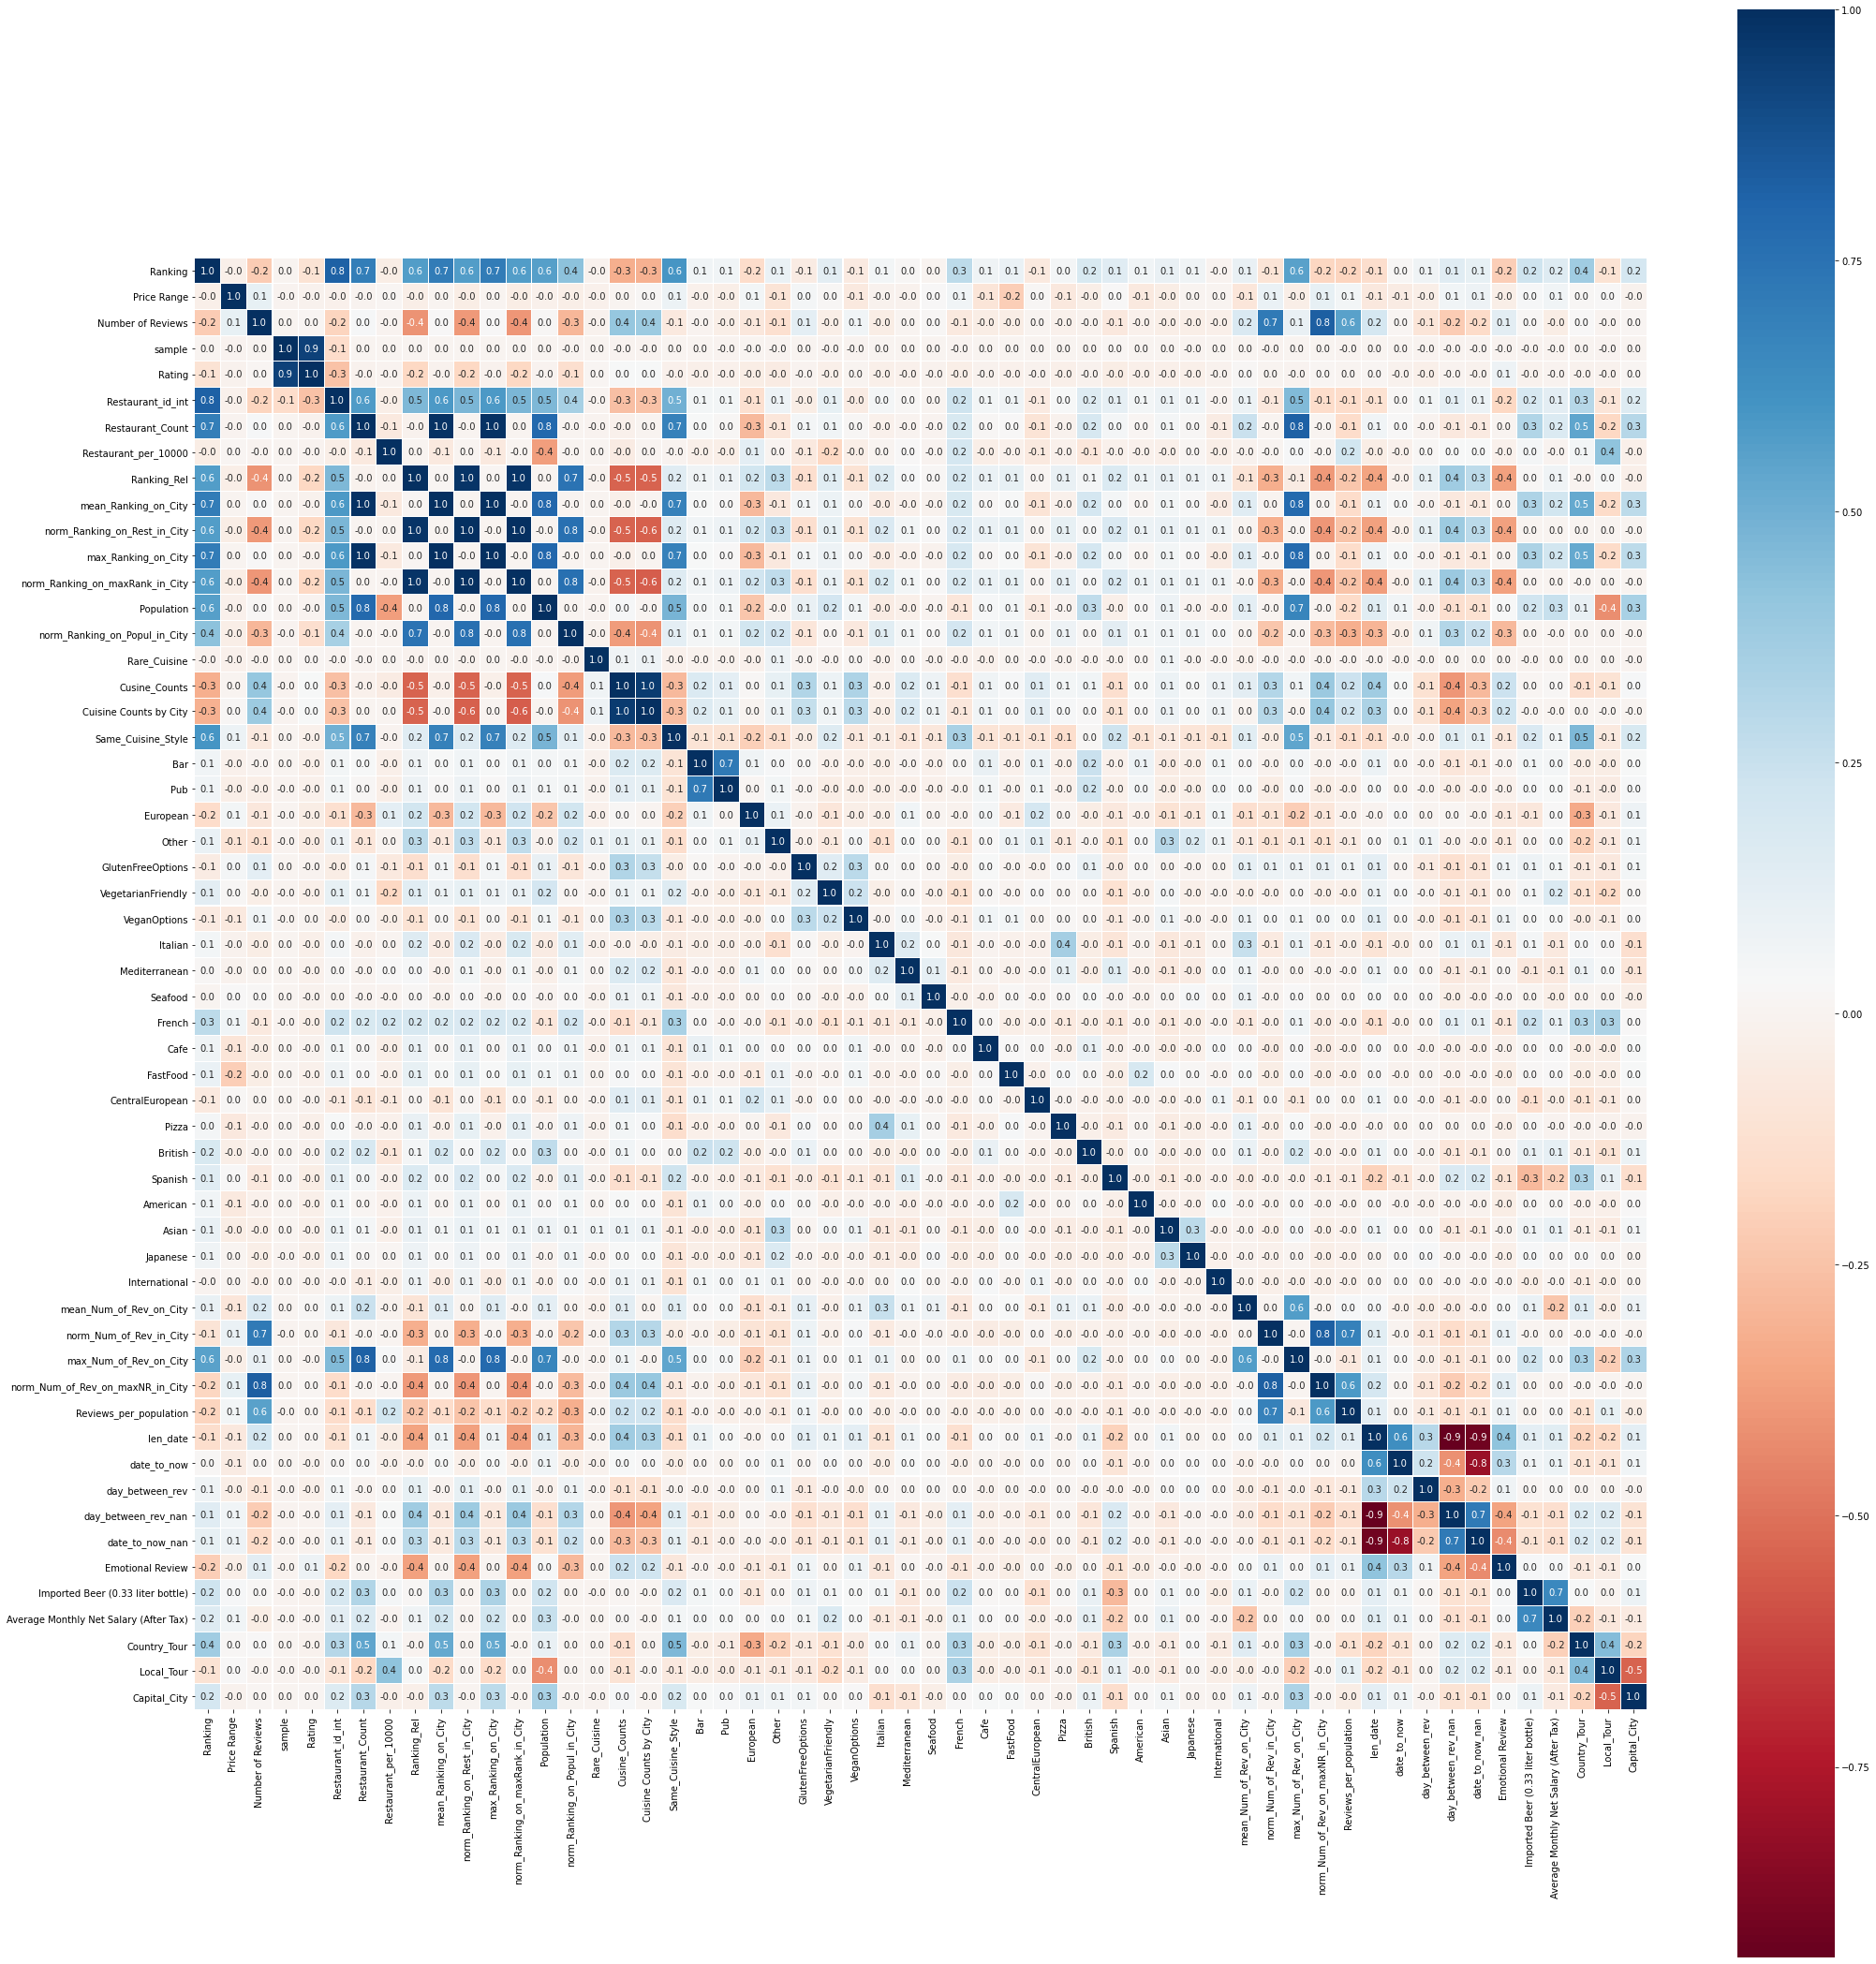

In [239]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data1.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

У нас есть целый ряд признаков, которые сильно скоррелированы с другими (нецелевыми!) признаками. Признак Restaurant Count скоррелирован со многими признаками, а с некоторыми из них корреляция 100%. Я думаю, что его можно убрать, чтобы модели легче работалось; признак max_Num_of_Rev_on_Cityсильно скоррелирован с большим количеством признаков; Cuisine_Counts и Cuisine_Counts_by_City стопроцентно скоррелированы (оставим только Cousine_Counts_by_city); сильно скоррелированы признаки Bar и Pub (оставим только Bar); Population очень скоррелирован с многими другими признаками, что и понятно - он же был использован для создания многих из них; 

У нас еще были "служебные" признаки, которые были нужны только для расчета действительно важных. Уберем - len_date, все признаки с nan в названии (которые показывают где были nan в основных признаках), mean_Ranking_on_City, Max_Ranking_on_City, mean и max_Num_Rev_on_City

Попробуем вычистить эти признаки из базы и посмотрим, что получится... 

Сделал вычисления на вычещенной базе и точность предсказний ухудшилась (хоть и незначительно). Не буду трогать в итоговом варианте. Такое же несильное но ухудшение результатов показала очистка данных от выбросов, так что чистку применять тоже не буду.

### Переведем Города в dummies

In [264]:
data_City_dummies = pd.get_dummies(data['City'], dummy_na=False).astype('float64')
data = pd.concat([data,data_City_dummies], axis=1)

Теперь начинаем готовить всю базу к использованию в модели

In [265]:
from sklearn.preprocessing import StandardScaler

Убираем из базы все нечисловые признаки

In [266]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [267]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data.columns):
    if i not in ['Rating','sample']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

Посмотрим как отработает база на модели :)

In [268]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [269]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [270]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 87), (40000, 87), (40000, 86), (32000, 86), (8000, 86))

In [271]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [272]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [273]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [274]:
y_pred

array([4.635, 4.915, 4.17 , ..., 4.565, 4.18 , 4.035])

Мы видим, что предсказанные моделью значения рейтинга очень вариабельны, тогда как значения рейтинга в датасете принимают значения от 0 до 5 с шагом 0.5. Проведем обработку результатов работы модели, чтобы привести к виду, требуемому для оценки эффективности

In [275]:
# функция стандартного математического округления
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

# функция округления кратно 0.5
def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5
    
# создание функции для векторов np
my_vec_round = np.vectorize(my_round)

In [276]:
y_pred1 = my_vec_round(y_pred)

In [277]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred1))

MAE: 0.169375


Text(0, 0.5, 'Ось Y')

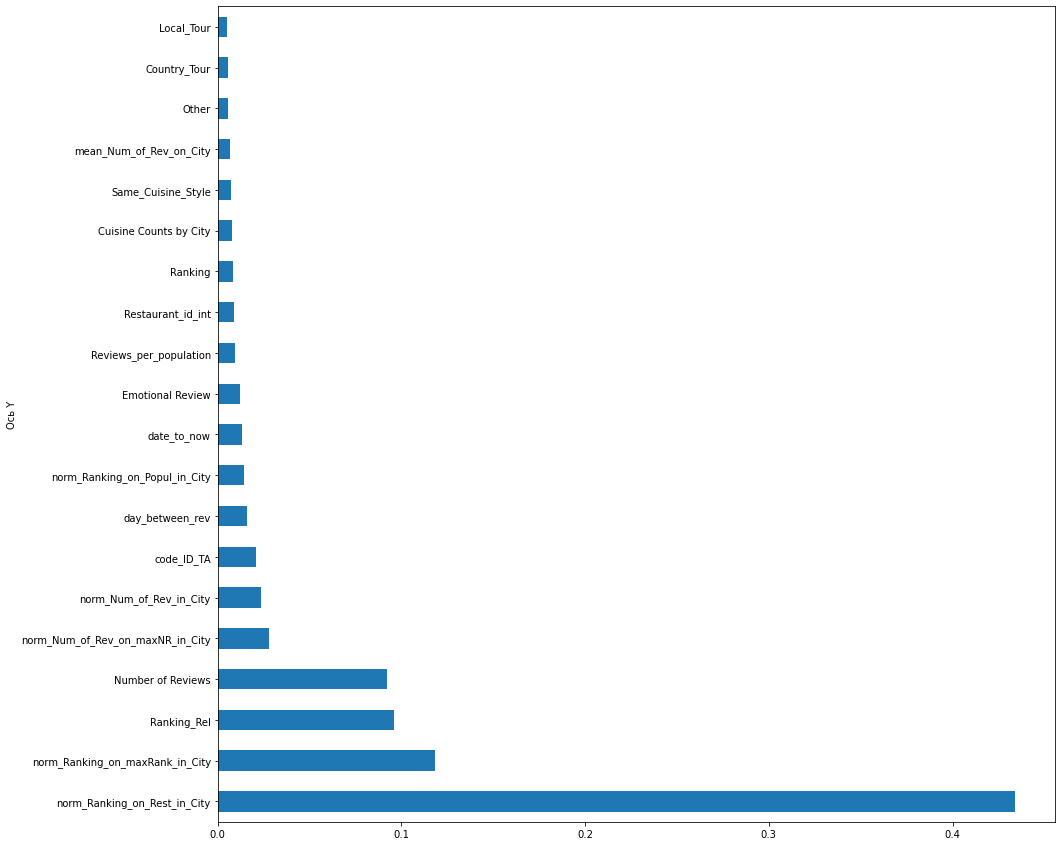

In [278]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.ylabel("Ось Y")

### Submission

In [500]:
test_data = test_data.drop(['Rating'], axis=1)

In [501]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [503]:
predict_submission=my_vec_round(predict_submission)
predict_submission

array([3.5, 4. , 4.5, ..., 3. , 4.5, 4.5])

In [505]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('azsubmission3.csv', index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5


### Вывод
С помощью опубликованных на Kaggle работ других студентов я сделал из имеющейся в исходном датасете информации много новых признаков (но я в большинстве случаев старался не копировать код коллег, а брал у них идею признака и старался описать ее своим кодом), я в течение работы над проектом делал много дополнительных признаков, взятых из сети (стоимость разных продуктов по гордам, признаки уровней жизни и т.п., но в итоге они никак не учитывались моделью и я в финальном проекте оставил только стоимость пива и средний уровень зарплаты по городам), на удивление наличие dummies по стилям кухни никак позитивно не влияло на работу модели, поэтому не стал включать их в финальный проект (хотя, на предврительных этапах делал). "Откровением" для меня стала необходимость "дорабатывать" результат работы модели (приведение результатов к округленному до 0,5 значению улучшало МАЕ с 0,21 до 0,16 (!!!)). Я не использовал в работе графики распределения признака по той простой причине, что строить эти графики нас учили, а вот серьезной интерпретации их - нет.. Что-то я нагуглил, но на промежуточных этапах подготовки проекта эта информация показала себя совершенно бесполезной. В качестве личной "радости" - я сумел сам оптимизировать вычисление одного из признаков и вычисление, занимавшее 2,5 часа, стало проходить за 30 секунд (догадался сам, даже без помощи Google).